# **CS 6735 ANN - Intro**

This is the notebook for the development of an artificial neural network from scratch for CS 6735. The purpose of this network is to perform a binary classification between malignant and benign tumours within a dataset of medical data about breast cancer.

This ANN is to be developed from scratch, and must include:

* a typical ANN structure (input, some number of hidden, output)
* back propagation as the method of updating weights

This code was developed by Matthew Tidd.

**DATE CREATED: 13/11/2024**

**DATE MODIFIED: 13/11/2024**

# **Importing Packages**

Must first import the following packages:

In [3]:
# import packages:
from ucimlrepo import fetch_ucirepo
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt


# **Load the Dataset**

Need to load the dataset. This dataset can be found on the UC Irvine Machine Learning Repository, and was donated from the University of Wisconsin-Madison in 1995. It is considered a multivariate dataset, and consists of several features pertaining to breast mass that were computed from digitized images of fine needle aspirate. These features describe the characteristics of the cell nuclei present in the image. 

There are 10 real-valued features that are of importance for this dataset:

* radius
* texture
* perimeter
* area
* smoothness
* compactness
* concavity
* concave points
* symmetry
* fractal dimension

For each of these real-valued features there are 3 versions, representing the mean, standard deviation, and worst case value. 

In total there are 30 features and 569 instances. The target variable in this dataset is a diagnosis, either malignant or benign. This dataset can be found at:

https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic

In [4]:
# because the dataset is from the UCI ML repo, we can use their functions to fetch from their website:

breast_data = fetch_ucirepo(id = 17)

# can now access the data:

breast_x = breast_data.data.features
breast_y = breast_data.data.targets

# **Examine Dataset Properties**:

Going to examine the properties of the dataset as part of an exploratory analysis.

In [5]:
# get the total number of instances:
print(f"there are {breast_x.shape[0]} examples in the dataset")

# get number of features:
print(f"there are {breast_x.shape[1]} distinct features to train on")

# get the number of unique target variables:
print(f"the available diagnoses are: {breast_y['Diagnosis'].unique()}")

# get the names of the features:
print(f"the available features are: \n")
for col in breast_x.columns:
    print(col)

there are 569 examples in the dataset
there are 30 distinct features to train on
the available diagnoses are: ['M' 'B']
the available features are: 

radius1
texture1
perimeter1
area1
smoothness1
compactness1
concavity1
concave_points1
symmetry1
fractal_dimension1
radius2
texture2
perimeter2
area2
smoothness2
compactness2
concavity2
concave_points2
symmetry2
fractal_dimension2
radius3
texture3
perimeter3
area3
smoothness3
compactness3
concavity3
concave_points3
symmetry3
fractal_dimension3


With 30 distinct features in the dataset, one must wonder what features are actually important in predicting malignant or benign tumours. This exploratory analysis therefore seeks to examine the predictive power and importance of the features:

c:\Users\mtidd\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


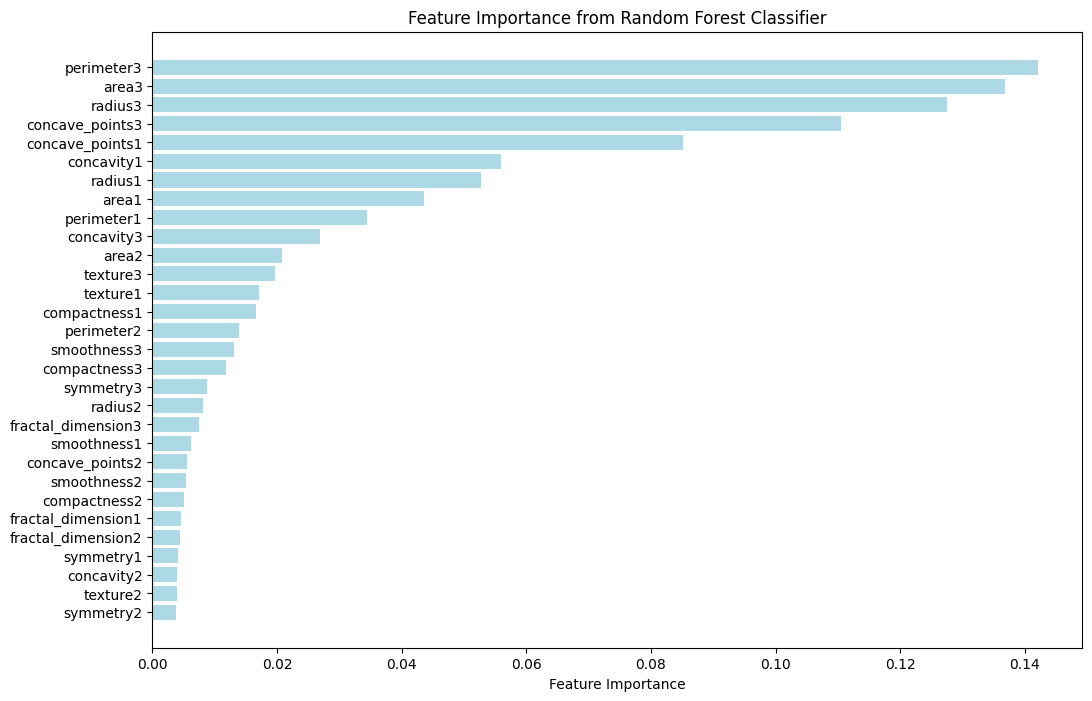

In [6]:
# check the feature importance:

rf = RandomForestClassifier(n_estimators=100)
rf.fit(breast_x, breast_y)

# get feature importances
importances = rf.feature_importances_

# convert to dataframe:
features = breast_x.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})

# sort the features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# plot the feature importances
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='lightblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importance from Random Forest Classifier')
plt.gca().invert_yaxis()  # To show the most important features on top
plt.show()

# **Dataset Pre-Processing**:

Going to pre-process the dataset by performing the following:

* remove the null values
* scale the feature values to within a common range
* encode the categorical labels into binary 0 or 1

This is done to help realize the best model performance given the dataset.

In [7]:
# check for null values in the features:

null = breast_x.isnull().values.any()
if null == True:
    breast_x = breast_x.dropna()
    print(f'null values removed from features')
else:
    print(f'no null values detected in features')

# check for null values in the labels:

null = breast_y.isnull().values.any()
if null == True:
    breast_y = breast_y.dropna()
    print(f'null values removed from labels')
else:
    print(f'no null values detected in labels')


no null values detected in features
no null values detected in labels


Standardize values to improve ANN performance:

In [8]:
# standardize values:

scaler = StandardScaler()
x_scaled = scaler.fit_transform(breast_x)
print('features scaled')

features scaled


Need to encode the categorical variables into binary values to be used in the ANN:

In [9]:
# encode benign to 0, and malignant to 1

breast_y = breast_y['Diagnosis'].map(lambda row: 1 if row == 'M' else 0)
print('labels encoded: M = 1, B = 0')
breast_y.head()

labels encoded: M = 1, B = 0


0    1
1    1
2    1
3    1
4    1
Name: Diagnosis, dtype: int64

# **ANN Function Definition**

Going to be using a class-based approach to defining the ANN, which will allow for instantiating, training, and querying of the network. Need to define the class itself as well as functions that will be used often, like the 
sigmoid function, relu, and their derivatives:


In [21]:
# define useful functions:

# logistic sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# derivative of the sigmoid function
def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

# rectified linear unit (basically a straight line)
def relu(x):
    return np.maximum(0, x)

# derivative function of relu (accepts np.arrays)
def relu_derivative(x):
    return (x > 0).astype(float)

In [ ]:
# create neural network class:

class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        # assign function inputs as instance variables:
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # need to randomly initialize weights and biases for the layers:

        # from input to hidden:
        self.w1 = np.random.randn(hidden_size, input_size)
        self.b1 = np.random.randn(hidden_size, 1)

        # from hidden to output:
        self.w2 = np.random.randn(output_size, hidden_size)
        self.b2 = np.random.randn(output_size, 1)

    def forward_pass(self, x):
        # from input to hidden:
        self.net1 = np.dot(self.w1, x)
        self.h1 = np.relu(self.net1)

        # from hidden to output:
        self.net2 = np.dot(self.w2, self.h1)
        self.o = sigmoid(self.net2)

        return self.o
    
    def backward_pass(self, x, y, learning_rate):
        # get o - t:
        o_error = self.o - y

        # get gradients for weights and biases at the output layer:

        # get gradients for weights and biases at the input layer:

        # update weights and biases:

        self.w1 -= learning_rate  * de_dw1
        self.b1 -= learning_rate  * de_db1
        self.w2 -= learning_rate  * de_dw2
        self.b2 -= learning_rate  * de_db2



        

